# Carga de los DataFrames

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix,recall_score,precision_score

from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
def crear_df_ultimos_n_anios(anios):
    df_definitivo = []
    numero_anios = anios
    labels = []

    labels.append('Y')
    labels.append('Nombre')
    labels.append('Ultimo año disponible')
    labels.append('Fecha constitución')
    labels.append('Fecha cambio estado')


    for columna in columnas_anuales:
        for j in range(numero_anios-1,-1,-1):
            labels.append(columna+'-{}'.format(str(j)))

    for i in range(len(df_merged)):
        #print('ITERACION {}:'.format(str(i)))
        anio_constitucion = int(df_merged.iloc[i,3][:4])
        ultimo_anio = int(df_merged.iloc[i,2][-4:])
        #print(i,'ULTIMO AñO DISPONIBLE: {}, AÑO DE CONSTITUCION: {}'.format(ultimo_anio,anio_constitucion))
        if(anio_constitucion < 2002):
            anio_constitucion = 2002
        if(ultimo_anio < 2002):
            ultimo_anio = 2002

        anios_disponibles = ultimo_anio-anio_constitucion

        entrada_aux = []

        if(anios_disponibles >= numero_anios):
            entrada_aux.append(df_merged['Y'].iloc[i])
            entrada_aux.append(df_merged['Nombre'].iloc[i])
            entrada_aux.append(df_merged['Ultimo año disponible'].iloc[i])
            entrada_aux.append(df_merged['Fecha constitución'].iloc[i])
            entrada_aux.append(df_merged['Fecha cambio estado'].iloc[i])

            for columna in columnas_anuales:
                for j in range(ultimo_anio+1-numero_anios,ultimo_anio+1):
                    #print(i)
                    entrada_aux.append(df_merged[columna+'{}'.format(str(j))].iloc[i])


            df_definitivo.append(entrada_aux)



    df_definitivo = pd.DataFrame(df_definitivo,columns = labels)
    return df_definitivo


def rellenarNan(df,n,columnas_anuales,verbose=0):

    df_copia = df.copy()
    extremos = 0
    grupos_3 = 0
    grupos_4 = 0
    grupos_5 = 0

    indices = range(n-1,-1,-1)

    print('------------Rellenando extremos----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[0]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[1]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[0]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[1]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[0]))],df.loc[j,columna +'-{}'.format(str(indices[1]))])
                    extremos += 1

            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-2]))])==False:
                    df_copia.loc[j, columna +'-{}'.format(str(indices[-1]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[-2]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[-2]))],df.loc[j,columna +'-{}'.format(str(indices[-1]))])
                    extremos += 1

    print('------------Rellenando Dato-NaN-Dato----------')
    # Si hay dato-nan-dato, que se llene con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-3+1):
                if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                    grupos_3 += 1

    # Si hay dato-nan-nan-dato, rellenamos con la progresión lineal
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-4+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+2]))][j])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+3]))][j])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+3]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + media)/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = (df.loc[j,columna +'-{}'.format(str(indices[i+3]))] + media)/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))])
                    grupos_4 += 2

    # Si hay dato-nan-nan-nan-dato, rellenamos el del medio con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-5+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+3]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+4]))])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+4]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = media
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))],df.loc[j,columna +'-{}'.format(str(indices[i+4]))])
                    grupos_5 += 1



    if(grupos_5>0):
        df = df_copia
        df_copia = df.copy()
        print('------------Rellenando Dato-NaN-Dato----------')
        # Si hay dato-nan-dato, que se llene con la media
        for j in range(len(df)):
            for columna in columnas_anuales:
                for i in range(len(indices)-3+1):
                    if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                        df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                        if verbose:
                            print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                        grupos_3 += 1


    print('Extremos',extremos)
    print('Grupo 3', grupos_3)
    print('Grupo 4',grupos_4)
    print('Grupo 5',grupos_5)
    print('TOTAL',extremos+grupos_3+grupos_4+grupos_5)
    return df_copia



def rellenarNanHaciaAtras(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia atras----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = 0
            for i in range(n):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def rellenarNanHaciaAdelante(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia adelante----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = np.nan
            for i in range(n-1,-1,-1):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def eliminarFilasVacias(df,n,columnas_anuales,verbose=0):
    df_copia = df.copy()
    eliminados = 0

    print('------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------')

    for j in range(len(df)):
        if df.loc[j,'Y'] == 0:
            ya_eliminada = False
            for columna in columnas_anuales:
                if ya_eliminada == False:
                    vacias = 0
                    for i in range(n):
                        if(np.isnan(df.loc[j,columna+'-{}'.format(i)])):
                            vacias +=1
                    if vacias == n:
                        if verbose:
                            print(j,'-->',repr(columna))
                        df_copia.drop(j,axis=0,inplace=True)
                        eliminados += 1
                        ya_eliminada = True

    print(eliminados)
    df_copia.reset_index(drop=True,inplace=True)
    return df_copia

def limpiar(df,n,columnas_anuales,verbose=0):

    # Eliminamos aquellas filas (cuya etiqueta sea '0'), que para alguna variable anualizada tenga todos los valores vacios
    df = eliminarFilasVacias(df,n,columnas_anuales,verbose)
    # Rellenamos aquellos huecos que permitan extrapolar algo (grupos de 3, 4 y 5)
    df = rellenarNan(df,n,columnas_anuales,verbose)
    # Rellenamos los valores perdidos hacia atras
    df = rellenarNanHaciaAtras(df,n,columnas_anuales)
    # Rellenamos los valores perdidos hacia delante
    df = rellenarNanHaciaAdelante(df,n,columnas_anuales)

    return df

def calcularDeltas(df,n,columnas_anuales):
    df_nuevo = df.copy()

    indices = range(n-1,-1,-1)

    for columna in columnas_anuales:
        for i in range(len(indices)-1):
            df_nuevo[columna+'delta {}-{}'.format(indices[i],indices[i+1])] = ((df_nuevo[columna+'-{}'.format(indices[i+1])]/df_nuevo[columna+'-{}'.format(indices[i])])-1.0)*100

    return df_nuevo

In [3]:
paths_08_21 = [  'Datos/Sabi_Export_CNAE56_0.xlsx',
                 'Datos/Sabi_Export_CNAE56_1.xlsx',
                 'Datos/Sabi_Export_CNAE56_2.xlsx',
                 'Datos/Sabi_Export_CNAE56_3.xlsx',
                 'Datos/Sabi_Export_CNAE56_4.xlsx',
                 'Datos/Sabi_Export_CNAE56_5.xlsx',
                 'Datos/Sabi_Export_CNAE56_6.xlsx']

In [4]:
paths_00_07 = [ 'Datos/Sabi_Export_CNAE56_7.xlsx',
                'Datos/Sabi_Export_CNAE56_8.xlsx',
                'Datos/Sabi_Export_CNAE56_9.xlsx',
                'Datos/Sabi_Export_CNAE56_10.xlsx',
                'Datos/Sabi_Export_CNAE56_11.xlsx',
                'Datos/Sabi_Export_CNAE56_12.xlsx',
                'Datos/Sabi_Export_CNAE56_13.xlsx']

In [5]:
dfs = []
for path in paths_08_21:
    print(path)
    df = pd.read_excel(path,na_values='n.d.',sheet_name=1,index_col=False,decimal=",", thousands='.')
    df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


    df_anuales = df.columns[df.columns.str.contains('2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021',case = False)]
    df_anuales = df_anuales.drop('Código primario CNAE 2009')


    for columna in df_anuales:
        if df[columna].dtype == 'object':
            df[columna] = df[columna].astype('str').str.replace(',', '.')
            df[columna] = pd.to_numeric(df[columna],errors='coerce')


    df = df.drop(['Código NIF','Código consolidación','Dirección web','Dirección marketeable','Forma jurídica detallada','Estado detallado','Presidente','Código primario CNAE 2009', 'Director ejecutivo','Nombre marca','Nombre auditor','Opinión auditor','Localidad','Salvedades','Tipo cuentas dispon.','Ultimo número empleados','No of companies in corporate group','Número de participadas','Fecha boletín','Estado'],axis=1)
    dfs.append(df)

Datos/Sabi_Export_CNAE56_0.xlsx
Datos/Sabi_Export_CNAE56_1.xlsx
Datos/Sabi_Export_CNAE56_2.xlsx
Datos/Sabi_Export_CNAE56_3.xlsx
Datos/Sabi_Export_CNAE56_4.xlsx
Datos/Sabi_Export_CNAE56_5.xlsx
Datos/Sabi_Export_CNAE56_6.xlsx


In [6]:
for path in paths_00_07:
    print(path)
    df = pd.read_excel(path,na_values='n.d.',sheet_name=1,index_col=False,decimal=",", thousands='.')
    df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


    df_anuales = df.columns[df.columns.str.contains('2000|2001|2002|2003|2004|2005|2006|2007',case = False)]


    for columna in df_anuales:
        if df[columna].dtype == 'object':
            df[columna] = df[columna].astype('str').str.replace(',', '.')
            df[columna] = pd.to_numeric(df[columna],errors='coerce')

    df.drop(['Nombre.1','Cotiza, no cotiza, cotizó','Indicator de\nIndependencia BvD','Código NIF'],axis=1,inplace=True)
    dfs.append(df)

Datos/Sabi_Export_CNAE56_7.xlsx
Datos/Sabi_Export_CNAE56_8.xlsx
Datos/Sabi_Export_CNAE56_9.xlsx
Datos/Sabi_Export_CNAE56_10.xlsx
Datos/Sabi_Export_CNAE56_11.xlsx
Datos/Sabi_Export_CNAE56_12.xlsx
Datos/Sabi_Export_CNAE56_13.xlsx


In [7]:
df_08_22 = pd.concat([dfs[0],dfs[1],dfs[2],dfs[3],dfs[4],dfs[5],dfs[6]],ignore_index=True,copy=True)

In [8]:
df_00_07 = pd.concat([dfs[7],dfs[8],dfs[9],dfs[10],dfs[11],dfs[12],dfs[13]],ignore_index=True,copy=True)

In [9]:
df_08_22

,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n2021,Rentabilidad sobre recursos propios (%)\n%\n2020,Rentabilidad sobre recursos propios (%)\n%\n2019,Rentabilidad sobre recursos propios (%)\n%\n2018,Rentabilidad sobre recursos propios (%)\n%\n2017,Rentabilidad sobre recursos propios (%)\n%\n2016,...,Gastos Servicios Profesionales\nEUR\n2017,Gastos Servicios Profesionales\nEUR\n2016,Gastos Servicios Profesionales\nEUR\n2015,Gastos Servicios Profesionales\nEUR\n2014,Gastos Servicios Profesionales\nEUR\n2013,Gastos Servicios Profesionales\nEUR\n2012,Gastos Servicios Profesionales\nEUR\n2011,Gastos Servicios Profesionales\nEUR\n2010,Gastos Servicios Profesionales\nEUR\n2009,Gastos Servicios Profesionales\nEUR\n2008
0,ELABORACION Y SUMINISTRO DE ALIMENTOS S.L. (EX...,2004-12-31,1985-11-29 00:00:00,2005-12-22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MIXOR S.A.,2021-12-31,1986-03-12 00:00:00,1986-03-12,47.252,51.835,418.516,-0.918,0.413,-0.171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SDH SIGLA SL,2020-12-31,2011-01-20 00:00:00,2011-02-08,NaN,-10.507,108.292,103.533,97.078,93.607,...,62749.0,62187.0,108543.0,65802.0,74516.0,NaN,NaN,NaN,NaN,NaN
3,SHIKKU 2007 SLU,2021-06-30,2007-11-15 00:00:00,2007-12-20,58.168,61.927,77.694,237.634,-100.172,33.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOSTELERIA ABORDO SL (EXTINGUIDA),2016-10-31,2001-01-26 00:00:00,2018-01-29,NaN,NaN,NaN,NaN,NaN,38.067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14279,VENDING PIZZA SA (EXTINGUIDA),2003-12-31,1999-03-24 00:00:00,2001-07-20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14280,VIALIZ S.L.,2002-12-31,1994-03-23 00:00:00,2012-12-13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14281,VINOTECA ASTURIANA SL (EXTINGUIDA),2005-12-31,1982-08-31 00:00:00,2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14282,WATERMELON LOS CRISTIANOS SL.,2021-12-31,2014-09-16 00:00:00,NaT,-3.048,-401.211,11.276,44.855,78.768,102.579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_00_07

,Nombre,Ultimo año disponible,Rentabilidad sobre recursos propios (%)\n%\n2007,Rentabilidad sobre recursos propios (%)\n%\n2006,Rentabilidad sobre recursos propios (%)\n%\n2005,Rentabilidad sobre recursos propios (%)\n%\n2004,Rentabilidad sobre recursos propios (%)\n%\n2003,Rentabilidad sobre recursos propios (%)\n%\n2002,Rentabilidad sobre recursos propios (%)\n%\n2001,Rentabilidad sobre recursos propios (%)\n%\n2000,...,Apalancamiento (%)\n%\n2001,Apalancamiento (%)\n%\n2000,Ratio de solvencia\n%\n2007,Ratio de solvencia\n%\n2006,Ratio de solvencia\n%\n2005,Ratio de solvencia\n%\n2004,Ratio de solvencia\n%\n2003,Ratio de solvencia\n%\n2002,Ratio de solvencia\n%\n2001,Ratio de solvencia\n%\n2000
0,ELABORACION Y SUMINISTRO DE ALIMENTOS S.L. (EX...,2004-12-31,NaN,NaN,NaN,40.973,47.631,51.063,54.416,-2.218,...,26.327,50.063,NaN,NaN,NaN,1.877,1.245,1.880,1.243,1.145
1,MIXOR S.A.,2021-12-31,12.884,14.112,11.937,12.217,7.010,8.062,-8.935,35.263,...,10.985,3.952,6.985,8.110,7.415,6.941,5.333,3.617,1.975,1.751
2,SDH SIGLA SL,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SHIKKU 2007 SLU,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOSTELERIA ABORDO SL (EXTINGUIDA),2016-10-31,22.698,14.210,27.629,31.793,38.224,99.522,145.576,NaN,...,16.143,NaN,0.959,0.993,1.080,1.203,1.129,1.284,1.113,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,VENDING PIZZA SA (EXTINGUIDA),2003-12-31,NaN,NaN,NaN,NaN,0.000,0.000,NaN,20.628,...,NaN,-187.886,NaN,NaN,NaN,NaN,0.000,0.000,NaN,11.509
13980,VIALIZ S.L.,2002-12-31,NaN,NaN,NaN,NaN,NaN,-304.825,-1951.379,-108.853,...,135.194,194.480,NaN,NaN,NaN,NaN,NaN,0.229,0.576,0.671
13981,VINOTECA ASTURIANA SL (EXTINGUIDA),2005-12-31,NaN,NaN,0.000,0.000,0.000,0.000,0.312,NaN,...,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,NaN
13982,WATERMELON LOS CRISTIANOS SL.,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_00_07.sort_values('Nombre',ignore_index=True,inplace=True)
df_00_07.drop_duplicates(inplace=True)

In [12]:
df_08_22.sort_values('Nombre',ignore_index=True,inplace=True)
df_08_22.drop_duplicates(inplace=True)

In [13]:
df_00_07

,Nombre,Ultimo año disponible,Rentabilidad sobre recursos propios (%)\n%\n2007,Rentabilidad sobre recursos propios (%)\n%\n2006,Rentabilidad sobre recursos propios (%)\n%\n2005,Rentabilidad sobre recursos propios (%)\n%\n2004,Rentabilidad sobre recursos propios (%)\n%\n2003,Rentabilidad sobre recursos propios (%)\n%\n2002,Rentabilidad sobre recursos propios (%)\n%\n2001,Rentabilidad sobre recursos propios (%)\n%\n2000,...,Apalancamiento (%)\n%\n2001,Apalancamiento (%)\n%\n2000,Ratio de solvencia\n%\n2007,Ratio de solvencia\n%\n2006,Ratio de solvencia\n%\n2005,Ratio de solvencia\n%\n2004,Ratio de solvencia\n%\n2003,Ratio de solvencia\n%\n2002,Ratio de solvencia\n%\n2001,Ratio de solvencia\n%\n2000
0,051-MADE IN BO SL,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100 JJ EXPANSION HOSTELERA SOCIEDAD LIMITADA.,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001PRADO16 SL.,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100EMOCIONS SL,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100M ATOCHA SL.,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,ÑAM ARTEA SOCIEDAD LIMITADA.,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13980,ÑAM GROS SL.,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13981,ÑAM MEGAPARK SOCIEDAD LIMITADA.,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13982,ÑAM RESTAURANTES SOCIEDAD LIMITADA.,2021-12-31,NaN,86.996,2022.152,55.775,46.002,109.98,NaN,NaN,...,NaN,NaN,NaN,0.626,0.488,0.737,1.108,1.013,NaN,NaN


In [14]:
df_08_22

,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n2021,Rentabilidad sobre recursos propios (%)\n%\n2020,Rentabilidad sobre recursos propios (%)\n%\n2019,Rentabilidad sobre recursos propios (%)\n%\n2018,Rentabilidad sobre recursos propios (%)\n%\n2017,Rentabilidad sobre recursos propios (%)\n%\n2016,...,Gastos Servicios Profesionales\nEUR\n2017,Gastos Servicios Profesionales\nEUR\n2016,Gastos Servicios Profesionales\nEUR\n2015,Gastos Servicios Profesionales\nEUR\n2014,Gastos Servicios Profesionales\nEUR\n2013,Gastos Servicios Profesionales\nEUR\n2012,Gastos Servicios Profesionales\nEUR\n2011,Gastos Servicios Profesionales\nEUR\n2010,Gastos Servicios Profesionales\nEUR\n2009,Gastos Servicios Profesionales\nEUR\n2008
0,051-MADE IN BO SL,2021-12-31,2006-11-17 00:00:00,2018-09-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100 JJ EXPANSION HOSTELERA SOCIEDAD LIMITADA.,2016-12-31,2013-10-29 00:00:00,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001PRADO16 SL.,2020-12-31,2010-02-12 00:00:00,2010-03-03,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100EMOCIONS SL,2021-12-31,2005-07-19 00:00:00,2020-01-30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100M ATOCHA SL.,2021-12-31,2009-09-10 00:00:00,2018-11-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14279,ÑAM ARTEA SOCIEDAD LIMITADA.,2021-12-31,2013-11-27 00:00:00,2013-11-27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14280,ÑAM GROS SL.,2021-12-31,2019-05-17 00:00:00,2019-05-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14281,ÑAM MEGAPARK SOCIEDAD LIMITADA.,2021-12-31,2018-04-30 00:00:00,2018-04-30,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14282,ÑAM RESTAURANTES SOCIEDAD LIMITADA.,2021-12-31,2000-12-27 00:00:00,2012-10-19,31.705,-12.669,38.099,35.496,39.408,42.719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_00_07.drop('Ultimo año disponible',axis=1,inplace=True)

In [16]:
df_merged = pd.merge(df_00_07,df_08_22,on='Nombre')

In [17]:
df_merged

,Nombre,Rentabilidad sobre recursos propios (%)\n%\n2007,Rentabilidad sobre recursos propios (%)\n%\n2006,Rentabilidad sobre recursos propios (%)\n%\n2005,Rentabilidad sobre recursos propios (%)\n%\n2004,Rentabilidad sobre recursos propios (%)\n%\n2003,Rentabilidad sobre recursos propios (%)\n%\n2002,Rentabilidad sobre recursos propios (%)\n%\n2001,Rentabilidad sobre recursos propios (%)\n%\n2000,Rentabilidad sobre capital empleado (%)\n%\n2007,...,Gastos Servicios Profesionales\nEUR\n2017,Gastos Servicios Profesionales\nEUR\n2016,Gastos Servicios Profesionales\nEUR\n2015,Gastos Servicios Profesionales\nEUR\n2014,Gastos Servicios Profesionales\nEUR\n2013,Gastos Servicios Profesionales\nEUR\n2012,Gastos Servicios Profesionales\nEUR\n2011,Gastos Servicios Profesionales\nEUR\n2010,Gastos Servicios Profesionales\nEUR\n2009,Gastos Servicios Profesionales\nEUR\n2008
0,051-MADE IN BO SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100 JJ EXPANSION HOSTELERA SOCIEDAD LIMITADA.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001PRADO16 SL.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100EMOCIONS SL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100M ATOCHA SL.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,ÑAM ARTEA SOCIEDAD LIMITADA.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13980,ÑAM GROS SL.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13981,ÑAM MEGAPARK SOCIEDAD LIMITADA.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13982,ÑAM RESTAURANTES SOCIEDAD LIMITADA.,NaN,86.996,2022.152,55.775,46.002,109.98,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_anuales = df_merged.columns[df_merged.columns.str.contains('2002',case = False)]

columnas_anuales = []

for col in df_anuales:
    columnas_anuales.append(col[:-4])

columnas_anuales

['Rentabilidad sobre recursos propios (%)\n%\n',
 'Rentabilidad sobre capital empleado (%)\n%\n',
 'Rentabilidad sobre el activo total (%)\n%\n',
 'Margen de beneficio (%)\n%\n',
 'Rotación de activos netos\n%\n',
 'Ratio de cobertura de intereses\n%\n',
 'Rotación de las existencias\n%\n',
 'Período de cobro (días)\ndías\n',
 'Período de crédito (días)\ndías\n',
 'Costes de los trabajadores / Ingresos de explotación (%)\n%\n',
 'Coste medio de los empleados\nmil\n',
 'Capital circulante por empleado\nmil\n',
 'Ingresos de explotación\nEUR\n',
 'Result. ordinarios antes Impuestos\nEUR\n',
 'Resultado del Ejercicio\nEUR\n',
 'Total activo\nEUR\n',
 'Fondos propios\nEUR\n',
 'Rentabilidad económica (%)\n%\n',
 'Rentabilidad financiera (%)\n%\n',
 'Liquidez general\n%\n',
 'Endeudamiento (%)\n%\n',
 'Número empleados\n',
 'Ratios de autonomía financiera a medio y largo plazo\n%\n',
 'Apalancamiento (%)\n%\n',
 'Ratio de solvencia\n%\n']

In [19]:
df_merged = df_merged.drop(['Incidencias Judiciales','Incidencias Judiciales, primera',
                            'Incidencias Judiciales, última','Reclamaciones administrativas','Reclamaciones administrativas, primera','Reclamaciones administrativas, última',
                            'Número de miembros actuales de las juntas directivas y de gestión','Número de miembros anteriores\nde las juntas y gestión','DM\nTambién un accionista',
                            'DM\nNivel de responsabilidad',
                            'Remuneraciones Auditor\nEUR\n2008','Remuneraciones Auditor\nEUR\n2009','Remuneraciones Auditor\nEUR\n2010','Remuneraciones Auditor\nEUR\n2011',
                            'Remuneraciones Auditor\nEUR\n2012','Remuneraciones Auditor\nEUR\n2013','Remuneraciones Auditor\nEUR\n2014','Remuneraciones Auditor\nEUR\n2015',
                            'Remuneraciones Auditor\nEUR\n2016','Remuneraciones Auditor\nEUR\n2017','Remuneraciones Auditor\nEUR\n2018','Remuneraciones Auditor\nEUR\n2019',
                            'Remuneraciones Auditor\nEUR\n2020','Remuneraciones Auditor\nEUR\n2021','Remuneración Consejo\nEUR\n2008','Remuneración Consejo\nEUR\n2009',
                            'Remuneración Consejo\nEUR\n2010','Remuneración Consejo\nEUR\n2011','Remuneración Consejo\nEUR\n2012','Remuneración Consejo\nEUR\n2013',
                            'Remuneración Consejo\nEUR\n2014','Remuneración Consejo\nEUR\n2015','Remuneración Consejo\nEUR\n2016','Remuneración Consejo\nEUR\n2017',
                            'Remuneración Consejo\nEUR\n2018','Remuneración Consejo\nEUR\n2019','Remuneración Consejo\nEUR\n2020','Remuneración Consejo\nEUR\n2021',
                            'Gastos Servicios Profesionales\nEUR\n2008','Gastos Servicios Profesionales\nEUR\n2009','Gastos Servicios Profesionales\nEUR\n2010',
                            'Gastos Servicios Profesionales\nEUR\n2011','Gastos Servicios Profesionales\nEUR\n2012','Gastos Servicios Profesionales\nEUR\n2013',
                            'Gastos Servicios Profesionales\nEUR\n2014','Gastos Servicios Profesionales\nEUR\n2015','Gastos Servicios Profesionales\nEUR\n2016',
                            'Gastos Servicios Profesionales\nEUR\n2017','Gastos Servicios Profesionales\nEUR\n2018','Gastos Servicios Profesionales\nEUR\n2019',
                            'Gastos Servicios Profesionales\nEUR\n2020','Gastos Servicios Profesionales\nEUR\n2021','Gastos Servicios Publicidad\nEUR\n2008',
                            'Gastos Servicios Publicidad\nEUR\n2009','Gastos Servicios Publicidad\nEUR\n2010','Gastos Servicios Publicidad\nEUR\n2011','Gastos Servicios Publicidad\nEUR\n2012',
                            'Gastos Servicios Publicidad\nEUR\n2013','Gastos Servicios Publicidad\nEUR\n2014','Gastos Servicios Publicidad\nEUR\n2015',
                            'Gastos Servicios Publicidad\nEUR\n2016','Gastos Servicios Publicidad\nEUR\n2017','Gastos Servicios Publicidad\nEUR\n2018','Gastos Servicios Publicidad\nEUR\n2019',
                            'Gastos Servicios Publicidad\nEUR\n2020','Gastos Servicios Publicidad\nEUR\n2021'],axis=1)

In [20]:
df_merged = df_merged.rename(columns={'Total activo\nEUR\n2002': 'Total Activo\nEUR\n2002',
                                      'Total activo\nEUR\n2003': 'Total Activo\nEUR\n2003',
                                      'Total activo\nEUR\n2004': 'Total Activo\nEUR\n2004',
                                      'Total activo\nEUR\n2005': 'Total Activo\nEUR\n2005',
                                      'Total activo\nEUR\n2006': 'Total Activo\nEUR\n2006',
                                      'Total activo\nEUR\n2007': 'Total Activo\nEUR\n2007'})

In [21]:
df_anuales = df_merged.columns[df_merged.columns.str.contains('2002',case = False)]

columnas_anuales = []

for col in df_anuales:
    columnas_anuales.append(col[:-4])

columnas_anuales

['Rentabilidad sobre recursos propios (%)\n%\n',
 'Rentabilidad sobre capital empleado (%)\n%\n',
 'Rentabilidad sobre el activo total (%)\n%\n',
 'Margen de beneficio (%)\n%\n',
 'Rotación de activos netos\n%\n',
 'Ratio de cobertura de intereses\n%\n',
 'Rotación de las existencias\n%\n',
 'Período de cobro (días)\ndías\n',
 'Período de crédito (días)\ndías\n',
 'Costes de los trabajadores / Ingresos de explotación (%)\n%\n',
 'Coste medio de los empleados\nmil\n',
 'Capital circulante por empleado\nmil\n',
 'Ingresos de explotación\nEUR\n',
 'Result. ordinarios antes Impuestos\nEUR\n',
 'Resultado del Ejercicio\nEUR\n',
 'Total Activo\nEUR\n',
 'Fondos propios\nEUR\n',
 'Rentabilidad económica (%)\n%\n',
 'Rentabilidad financiera (%)\n%\n',
 'Liquidez general\n%\n',
 'Endeudamiento (%)\n%\n',
 'Número empleados\n',
 'Ratios de autonomía financiera a medio y largo plazo\n%\n',
 'Apalancamiento (%)\n%\n',
 'Ratio de solvencia\n%\n']

In [22]:
df_merged['Y'] = np.where(df_merged['Nombre'].str.contains('EXTINGUIDA'),1,0)

In [23]:
print('Numero de datos (incluido perdidos):',df_merged.size)
print('Numero de datos perdidos:',df_merged.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df_merged.isnull().values.sum()/df_merged.size)*100.0,'%')

Numero de datos (incluido perdidos): 7761120
Numero de datos perdidos: 6117474
Porcentaje de datos perdidos: 78.82205145649081 %


In [24]:
df_merged.insert(0, 'Y', df_merged.pop('Y'))
df_merged.insert(2, 'Ultimo año disponible', df_merged.pop('Ultimo año disponible'))
df_merged.insert(3, 'Fecha constitución', df_merged.pop('Fecha constitución'))
df_merged.insert(4, 'Fecha cambio estado', df_merged.pop('Fecha cambio estado'))

In [25]:
df_merged['Ultimo año disponible'] = df_merged['Ultimo año disponible'].dt.strftime('%d/%m/%Y')

In [26]:
df_merged['Fecha constitución'] = df_merged['Fecha constitución'].astype(str)

In [27]:
df_merged['Fecha cambio estado'] = df_merged['Fecha cambio estado'].astype(str)

In [28]:
df_merged

,Y,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n2007,Rentabilidad sobre recursos propios (%)\n%\n2006,Rentabilidad sobre recursos propios (%)\n%\n2005,Rentabilidad sobre recursos propios (%)\n%\n2004,Rentabilidad sobre recursos propios (%)\n%\n2003,...,Ratio de solvencia\n%\n2017,Ratio de solvencia\n%\n2016,Ratio de solvencia\n%\n2015,Ratio de solvencia\n%\n2014,Ratio de solvencia\n%\n2013,Ratio de solvencia\n%\n2012,Ratio de solvencia\n%\n2011,Ratio de solvencia\n%\n2010,Ratio de solvencia\n%\n2009,Ratio de solvencia\n%\n2008
0,0,051-MADE IN BO SL,31/12/2021,2006-11-17 00:00:00,2018-09-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,100 JJ EXPANSION HOSTELERA SOCIEDAD LIMITADA.,31/12/2016,2013-10-29 00:00:00,2020-01-22,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1001PRADO16 SL.,31/12/2020,2010-02-12 00:00:00,2010-03-03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,100EMOCIONS SL,31/12/2021,2005-07-19 00:00:00,2020-01-30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,100M ATOCHA SL.,31/12/2021,2009-09-10 00:00:00,2018-11-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,0,ÑAM ARTEA SOCIEDAD LIMITADA.,31/12/2021,2013-11-27 00:00:00,2013-11-27,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13980,0,ÑAM GROS SL.,31/12/2021,2019-05-17 00:00:00,2019-05-17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13981,0,ÑAM MEGAPARK SOCIEDAD LIMITADA.,31/12/2021,2018-04-30 00:00:00,2018-04-30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13982,0,ÑAM RESTAURANTES SOCIEDAD LIMITADA.,31/12/2021,2000-12-27 00:00:00,2012-10-19,NaN,86.996,2022.152,55.775,46.002,...,3.131,3.821,1.382,1.693,1.373,NaN,NaN,NaN,NaN,NaN


In [29]:
df_merged.drop(6669,inplace=True)
df_merged.drop(12022,inplace=True)

In [30]:
df = crear_df_ultimos_n_anios(5)

In [31]:
print('Numero de datos (incluido perdidos):',df.size)
print('Numero de datos perdidos:',df.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 1247090
Numero de datos perdidos: 784743
Porcentaje de datos perdidos: 62.925931568691915 %


In [32]:
df

,Y,Nombre,Ultimo año disponible,Fecha constitución,Fecha cambio estado,Rentabilidad sobre recursos propios (%)\n%\n-4,Rentabilidad sobre recursos propios (%)\n%\n-3,Rentabilidad sobre recursos propios (%)\n%\n-2,Rentabilidad sobre recursos propios (%)\n%\n-1,Rentabilidad sobre recursos propios (%)\n%\n-0,...,Apalancamiento (%)\n%\n-4,Apalancamiento (%)\n%\n-3,Apalancamiento (%)\n%\n-2,Apalancamiento (%)\n%\n-1,Apalancamiento (%)\n%\n-0,Ratio de solvencia\n%\n-4,Ratio de solvencia\n%\n-3,Ratio de solvencia\n%\n-2,Ratio de solvencia\n%\n-1,Ratio de solvencia\n%\n-0
0,0,051-MADE IN BO SL,31/12/2021,2006-11-17 00:00:00,2018-09-21,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1001PRADO16 SL.,31/12/2020,2010-02-12 00:00:00,2010-03-03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,100EMOCIONS SL,31/12/2021,2005-07-19 00:00:00,2020-01-30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,100M ATOCHA SL.,31/12/2021,2009-09-10 00:00:00,2018-11-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,101 BOCATAS SL,31/12/2021,1998-07-23 00:00:00,1998-07-23,9.803,14.578,11.089,-3258.273,360.592,...,2.871,0.0,80.007,7646.190,-2173.116,1.064,1.070,1.172,0.493,0.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,0,ZULE RESTAURANTES SL,31/12/2021,2011-11-02 00:00:00,2011-11-02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9589,1,ZURITA 15 S.L. (EXTINGUIDA),31/12/2007,1998-12-30 00:00:00,2008-12-01,NaN,43.840,45.890,26.827,132.228,...,NaN,0.0,0.000,0.000,0.000,NaN,1.879,2.323,0.884,0.243
9590,0,ZURRIONDA SL.,31/12/2020,2015-01-07 00:00:00,2015-01-07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9591,0,ÑAM ARTEA SOCIEDAD LIMITADA.,31/12/2021,2013-11-27 00:00:00,2013-11-27,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df['Y']

0       0
1       0
2       0
3       0
4       0
       ..
9588    0
9589    1
9590    0
9591    0
9592    0
Name: Y, Length: 9593, dtype: int32

In [34]:
df.to_csv('CNAE56-5años.csv')

In [35]:
df = limpiar(df,5,columnas_anuales,verbose=0)

------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------
6056
------------Rellenando extremos----------
------------Rellenando Dato-NaN-Dato----------
------------Rellenando Dato-NaN-Dato----------
Extremos 5889
Grupo 3 3866
Grupo 4 2144
Grupo 5 182
TOTAL 12081
------------Rellenando hacia atras----------
------------Rellenando hacia adelante----------


In [36]:
print('Numero de datos (incluido perdidos):',df.size)
print('Numero de datos perdidos:',df.isnull().values.sum())
print('Porcentaje de datos perdidos:',(df.isnull().values.sum()/df.size)*100.0,'%')

Numero de datos (incluido perdidos): 459810
Numero de datos perdidos: 0
Porcentaje de datos perdidos: 0.0 %


In [37]:
df['Y']

0       0
1       0
2       0
3       0
4       0
       ..
3532    1
3533    1
3534    0
3535    1
3536    0
Name: Y, Length: 3537, dtype: int32

# Imbalanced Learning

In [38]:
X = df.copy()
Y = X['Y']
X.drop('Y',inplace=True,axis=1)

X.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [39]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [40]:
print('Conjunto de entrenamiento %s' % Counter(Y_train))
print('Conjunto de prueba %s' % Counter(Y_test))

Conjunto de entrenamiento Counter({0: 1779, 1: 590})
Conjunto de prueba Counter({0: 883, 1: 285})


## Baseline

Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 75.60% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 87.59% test recall 51.23% test precision 96.05%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 89.73% test recall 64.56% test precision 90.64%


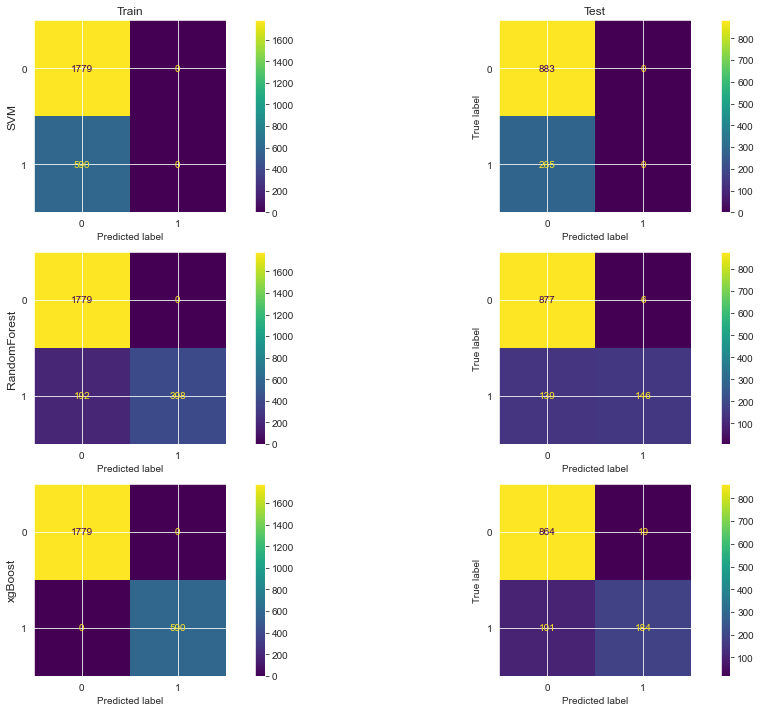

In [41]:
param_svm = {
    'C' : [0.001],
    'kernel': ['rbf'],
    'gamma' :[0.001]
}


param_rf = {
    'n_estimators':[250],
    'max_depth' : [8],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [200],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True)
    busqueda.fit(X_train,Y_train)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                    recall_score(Y_test,busqueda.predict(X_test)),
                                                                                    precision_score(Y_test,busqueda.predict(X_test))))

    plot_confusion_matrix(busqueda,
                        X_train,
                        Y_train,
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda,
                        X_test,
                        Y_test,
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.show()

## Baseline DELTAS

In [42]:
df_deltas = calcularDeltas(df,5,columnas_anuales)

In [43]:
X_deltas = df_deltas.copy()
Y_deltas = X_deltas['Y']
X_deltas.drop('Y',inplace=True,axis=1)

X_deltas.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [44]:
def infnan(x):
    x.fillna(value=0.0,inplace=True)
    x.replace([np.inf, -np.inf], 0, inplace=True)
    return x

In [45]:
X_deltas = infnan(X_deltas)

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 75.86% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200, 'random_state': 42}
test acurracy 87.67% test recall 49.29% test precision 99.29%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 88.27% test recall 58.16% test precision 89.62%


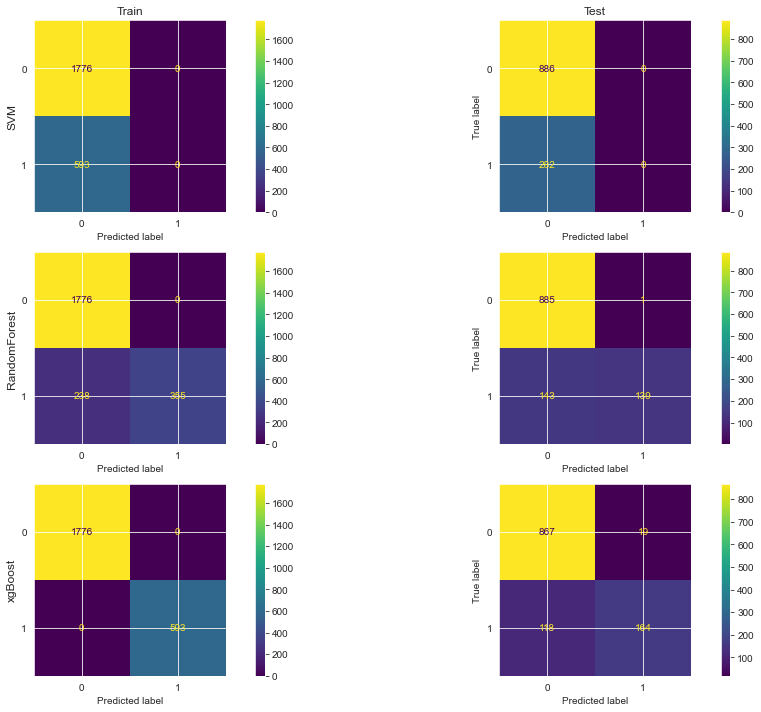

In [46]:
### APARECIDOS
param_svm = {
    'C' : [0.0001],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200],
    'max_depth' : [7],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados_delta_base = []



fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
X_train_deltas,X_test_deltas,Y_train_deltas,Y_test_deltas = train_test_split(X_deltas,Y_deltas,test_size=0.33)

for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
    busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
    busqueda.fit(X_train_deltas,Y_train_deltas)
    print('Buscando ({})'.format(modelo))
    print('Mejores parametros:',busqueda.best_params_)
    print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test_deltas),
                                                                                    recall_score(Y_test_deltas,busqueda.predict(X_test_deltas)),
                                                                                    precision_score(Y_test_deltas,busqueda.predict(X_test_deltas))))

    plot_confusion_matrix(busqueda,
                        X_train_deltas,
                        Y_train_deltas,
                        ax=axes[ind,0])
    #axes[ind,0].title.set_text('Train')

    plot_confusion_matrix(busqueda,
                        X_test_deltas,
                        Y_test_deltas,
                        ax=axes[ind,1])
    #axes[ind,1].title.set_text('Test')

    entrenados_delta_base.append(busqueda)

for ax,col in zip(axes[0],['Train','Test']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], modelos):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
plt.show()

## Oversampling - Optimista

ROSE
Conjunto de entrenamiento (resampleado) Counter({0: 1779, 1: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 88.70% test recall 64.56% test precision 85.58%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 89.64% test recall 65.26% test precision 89.42%


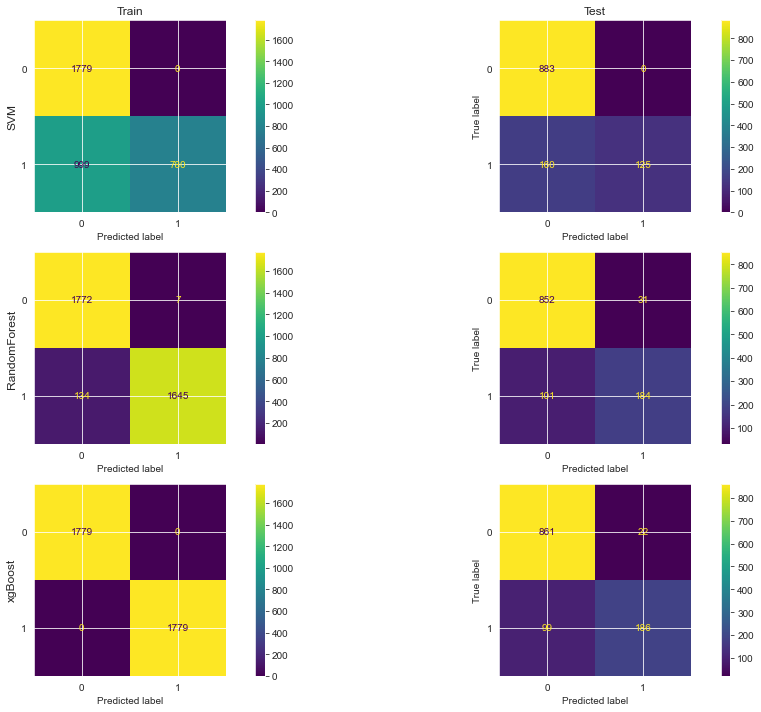

ADASYN
Conjunto de entrenamiento (resampleado) Counter({1: 1896, 0: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 24.40% test recall 100.00% test precision 24.40%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 80.48% test recall 75.79% test precision 57.60%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 85.36% test recall 65.26% test precision 72.09%


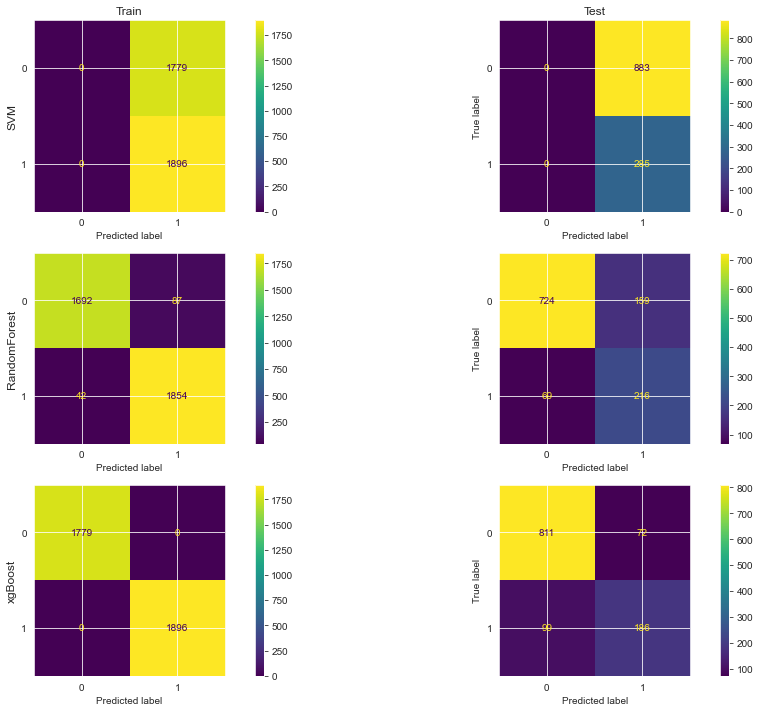

SMOTE
Conjunto de entrenamiento (resampleado) Counter({0: 1779, 1: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 86.22% test recall 63.86% test precision 75.83%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 88.44% test recall 70.18% test precision 80.00%


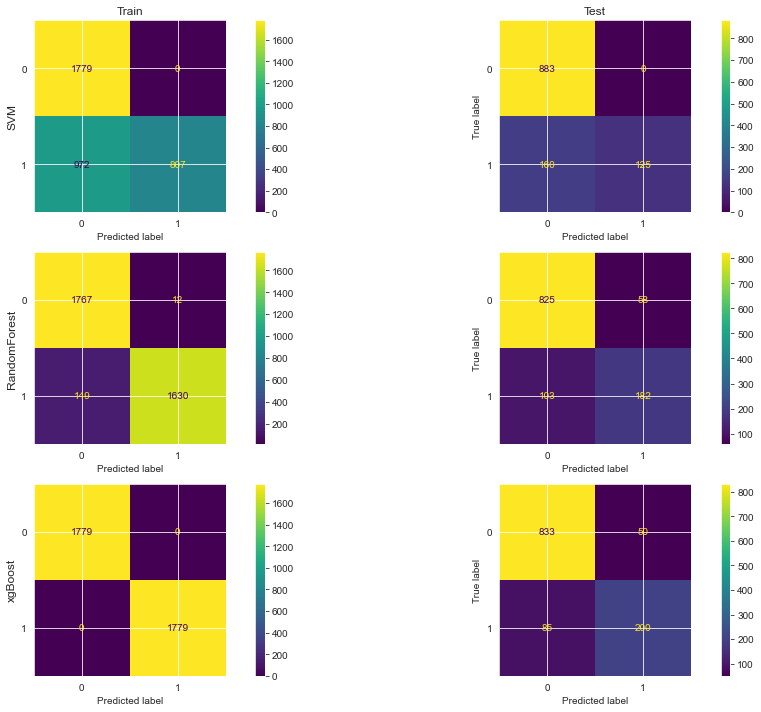

In [47]:
param_svm = {
    'C' : [0.001],
    'kernel': ['rbf'],
    'gamma' :[0.001]
}


param_rf = {
    'n_estimators':[250],
    'max_depth' : [8],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [200],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
samplers = [RandomOverSampler(),ADASYN(),SMOTE()]
upsamplers = ['ROSE','ADASYN','SMOTE']
entrenados = []





for algo,upsa in zip(samplers,upsamplers):
    print(upsa)
    X_res,y_res = algo.fit_resample(X_train,Y_train)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))
    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True)
        busqueda.fit(X_res,y_res)
        print('Buscando ({})'.format(modelo))
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                        recall_score(Y_test,busqueda.predict(X_test)),
                                                                                        precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Oversampling - Pipeline

In [48]:
from imblearn.pipeline import make_pipeline

ROSE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 88.44% test recall 62.81% test precision 86.06%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 250, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 89.64% test recall 67.02% test precision 87.61%


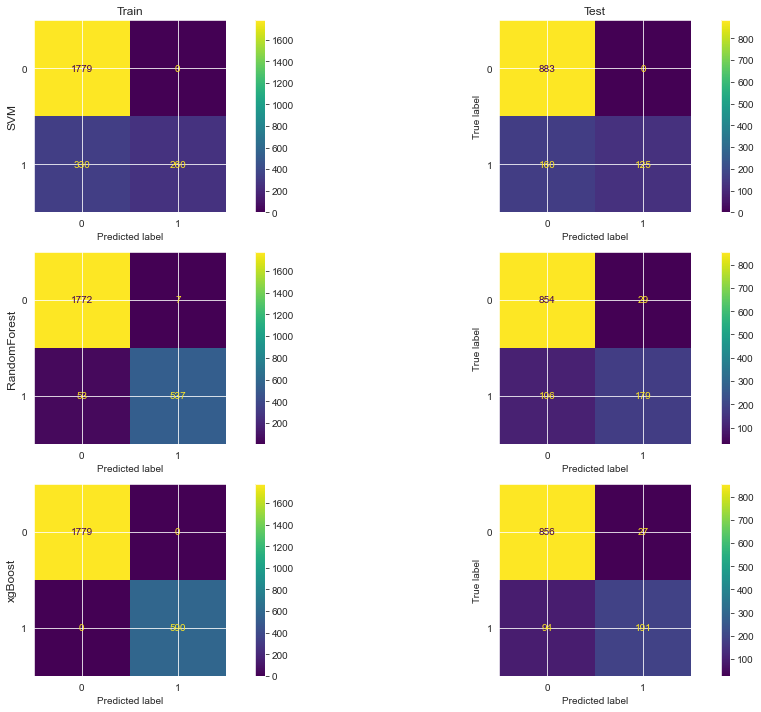

ADASYN
SVM
Mejores parametros: {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 82.19% test recall 77.19% test precision 60.61%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 86.30% test recall 69.12% test precision 73.23%


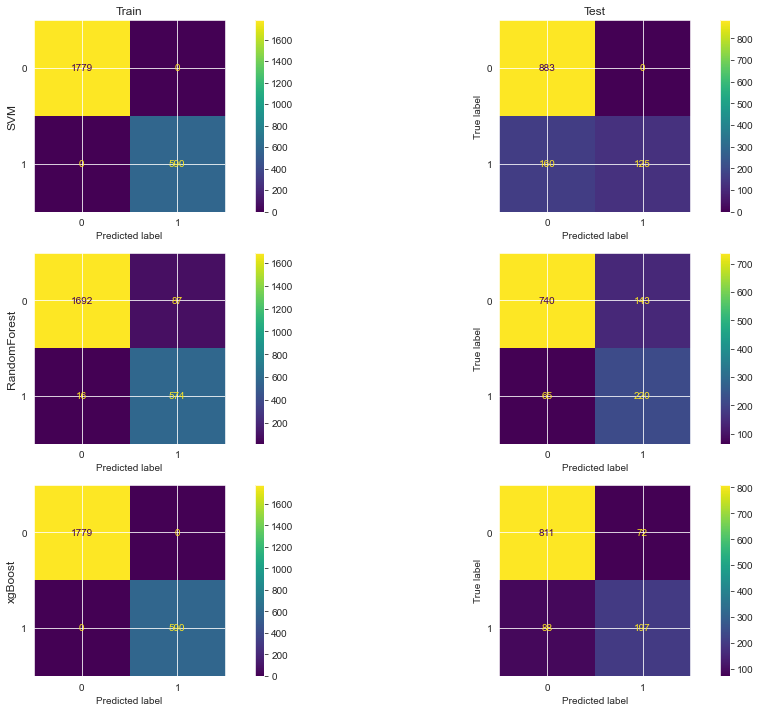

SMOTE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 85.19% test recall 63.51% test precision 72.40%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 87.59% test recall 69.47% test precision 77.34%


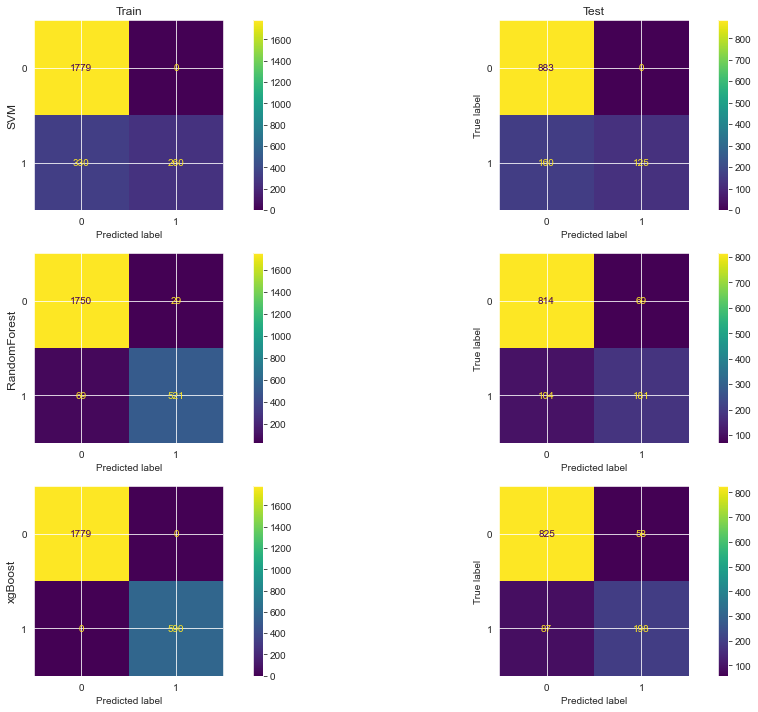

In [49]:
param_svm = {
    'svc__C' : [0.0001,1],
    'svc__kernel': ['rbf'],
    'svc__gamma' : [0.0001]
}


param_rf = {
    'randomforestclassifier__n_estimators':[250,300],
    'randomforestclassifier__max_depth' : [8],
    'randomforestclassifier__criterion' : ['entropy','gini'],
    'randomforestclassifier__random_state': [42]
}


param_xgb = {
    'xgbclassifier__max_depth' : [5,6],
    'xgbclassifier__learning_rate' : [0.1],
    'xgbclassifier__n_estimators' : [200,250,300],
    'xgbclassifier__gamma' : [0],
    'xgbclassifier__reg_alpha' : [0.1],
    'xgbclassifier__random_state': [42]
}


oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados = []


for algo,sampler in zip(oversampling,oversamplers):
    print(sampler)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        imblearn_pipeline = make_pipeline(algo, estimador)
        grid_imba = GridSearchCV(imblearn_pipeline, param_grid=params,scoring='accuracy',refit = True,n_jobs=-1)
        grid_imba.fit(X_train, Y_train);
        print(modelo)
        print('Mejores parametros:',grid_imba.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(grid_imba.score(X_test,Y_test),
                                                                                     recall_score(Y_test,grid_imba.predict(X_test)),
                                                                                     precision_score(Y_test,grid_imba.predict(X_test))))

        plot_confusion_matrix(grid_imba,
                            X_train,
                            Y_train,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(grid_imba,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Oversampling DELTAS - Optimista

In [50]:
X_test_deltas = calcularDeltas(X_test,5,columnas_anuales)
X_test_deltas.fillna(value=0.0,inplace=True)
X_test_deltas = infnan(X_test_deltas)

ROSE
Conjunto de entrenamiento (resampleado) Counter({0: 1779, 1: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 88.44% test recall 63.16% test precision 85.71%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 89.64% test recall 65.96% test precision 88.68%


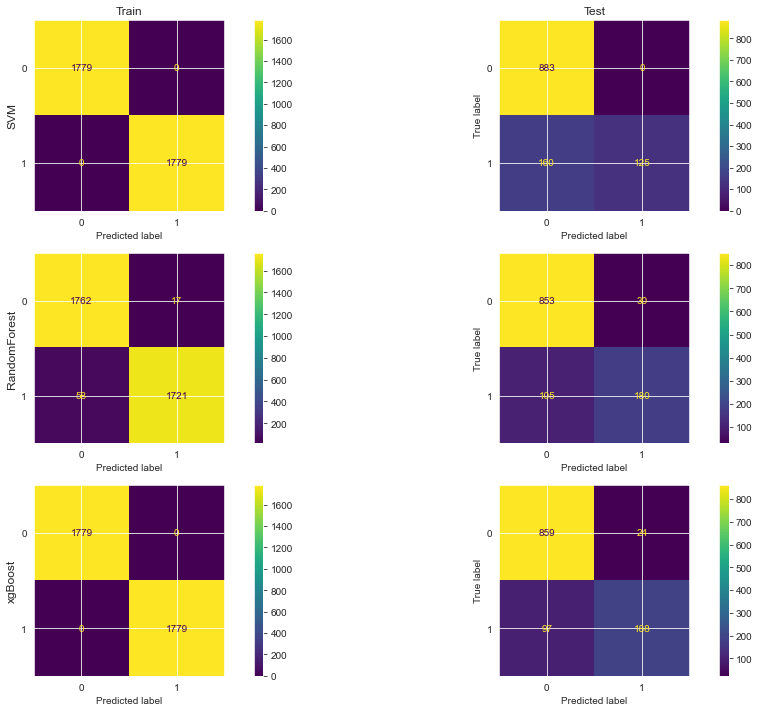

ADASYN
Conjunto de entrenamiento (resampleado) Counter({1: 1896, 0: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
SVM
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 24.40% test recall 100.00% test precision 24.40%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 81.76% test recall 80.00% test precision 59.38%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 88.18% test recall 72.28% test precision 77.74%


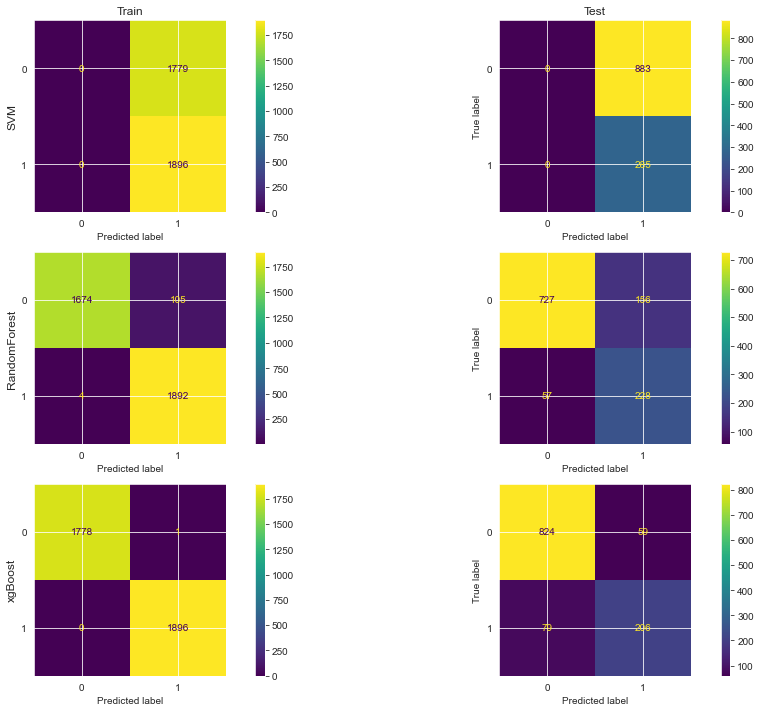

SMOTE
Conjunto de entrenamiento (resampleado) Counter({0: 1779, 1: 1779})
Conjunto de prueba Counter({0: 883, 1: 285})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 87.59% test recall 65.61% test precision 79.91%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 88.87% test recall 69.12% test precision 82.43%


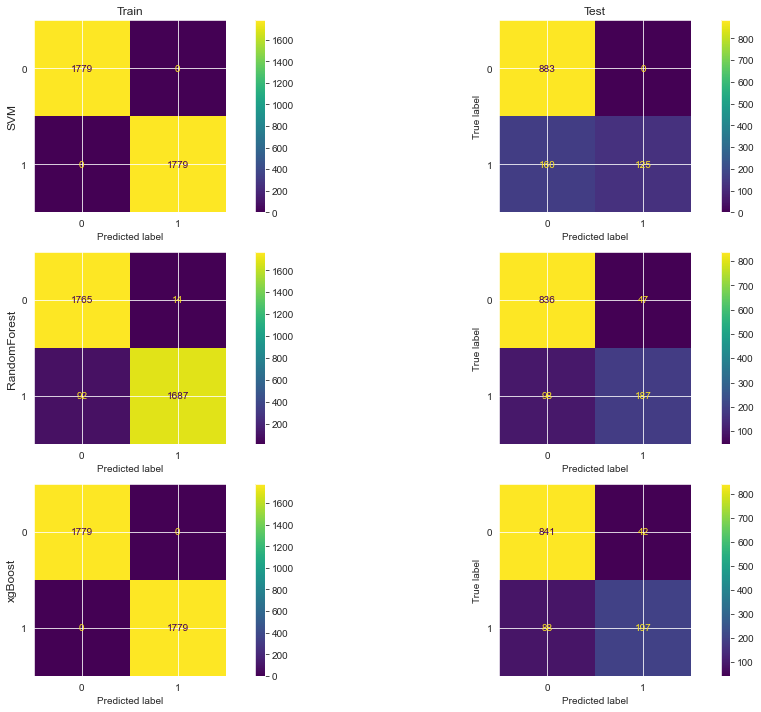

In [51]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200,300],
    'max_depth' : [8],
    'criterion' : ['entropy','gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6],
    'learning_rate' : [0.1],
    'n_estimators' : [250,300],
    'gamma' : [0],
    'reg_alpha' : [0.01,0.1],
    'random_state': [42]
}

modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    X_res = calcularDeltas(X_res,5,columnas_anuales)
    X_res = infnan(X_res)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test_deltas)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test_deltas))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test_deltas,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Oversampling DELTAS - Pipeline

In [52]:
from functools import partial

In [53]:
from sklearn.preprocessing import FunctionTransformer

In [54]:
def infnan(x):
    x.fillna(value=0.0,inplace=True)
    x.replace([np.inf, -np.inf], 0, inplace=True)
    return x

In [55]:
deltasparcial = partial(calcularDeltas,n=5,columnas_anuales=columnas_anuales)

In [56]:
transformer_nan = FunctionTransformer(infnan,validate=False)

In [57]:
transformer = FunctionTransformer(deltasparcial,validate=False)

ROSE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 42}
test acurracy 88.44% test recall 61.40% test precision 87.50%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 89.81% test recall 67.02% test precision 88.43%


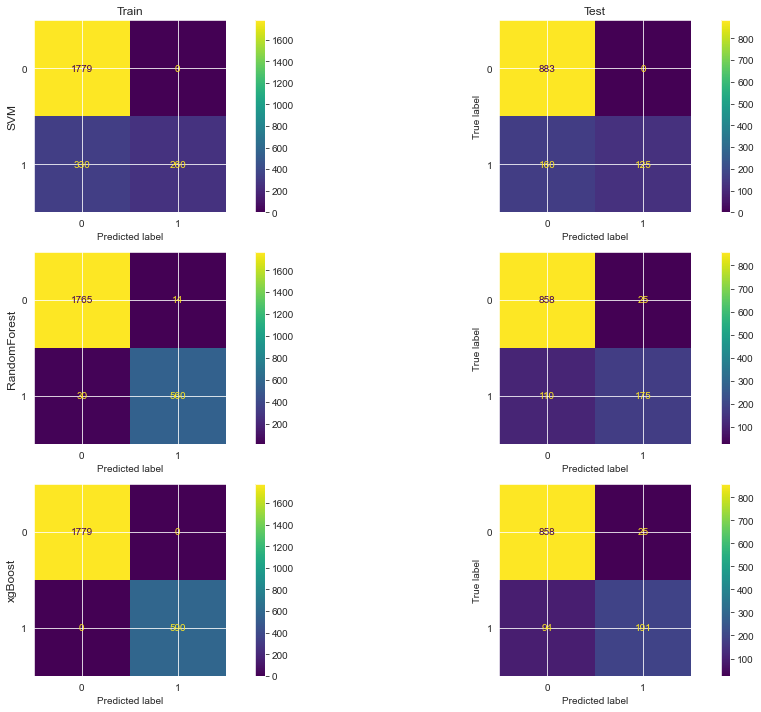

ADASYN
SVM
Mejores parametros: {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 83.39% test recall 82.46% test precision 62.01%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 87.50% test recall 72.98% test precision 75.09%


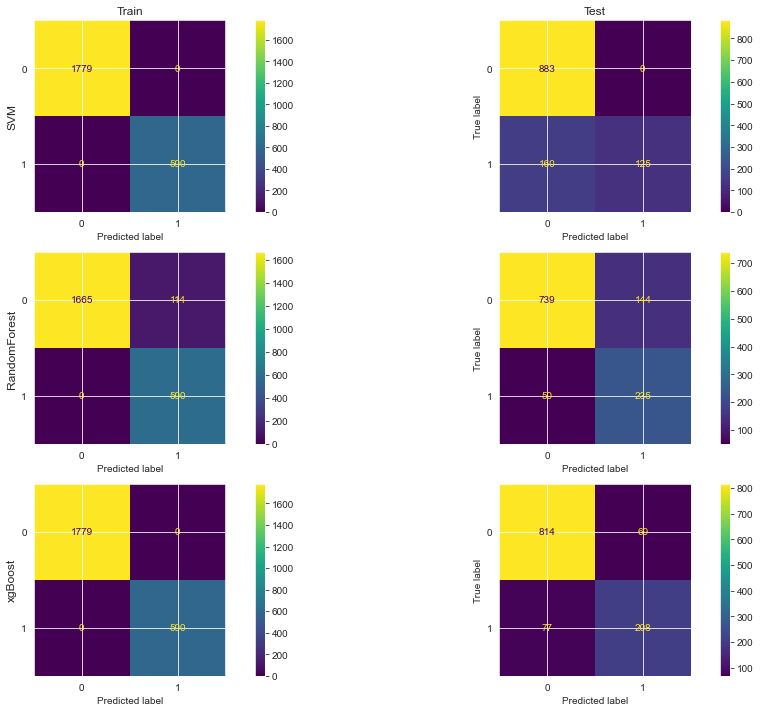

SMOTE
SVM
Mejores parametros: {'svc__C': 0.0001, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__random_state': 42}
test acurracy 87.59% test recall 62.81% test precision 82.11%
xgBoost
Mejores parametros: {'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 300, 'xgbclassifier__random_state': 42, 'xgbclassifier__reg_alpha': 0.1}
test acurracy 88.87% test recall 70.88% test precision 81.12%


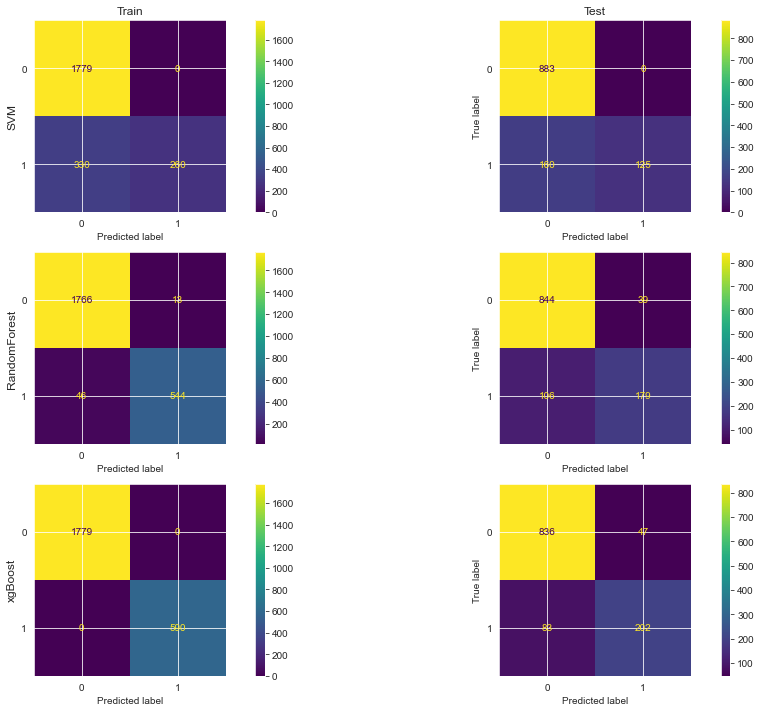

In [58]:
param_svm = {
    'svc__C' : [0.0001,1],
    'svc__kernel': ['rbf'],
    'svc__gamma' : [0.0001]
}


param_rf = {
    'randomforestclassifier__n_estimators':[250,300],
    'randomforestclassifier__max_depth' : [8],
    'randomforestclassifier__criterion' : ['entropy','gini'],
    'randomforestclassifier__random_state': [42]
}


param_xgb = {
    'xgbclassifier__max_depth' : [5,6],
    'xgbclassifier__learning_rate' : [0.1],
    'xgbclassifier__n_estimators' : [200,250,300],
    'xgbclassifier__gamma' : [0],
    'xgbclassifier__reg_alpha' : [0.1],
    'xgbclassifier__random_state': [42]
}


oversampling = [RandomOverSampler(),ADASYN(),SMOTE()]
oversamplers = ['ROSE','ADASYN','SMOTE']
modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
entrenados = []


for algo,sampler in zip(oversampling,oversamplers):
    print(sampler)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        imblearn_pipeline = make_pipeline(algo,transformer,transformer_nan,estimador)
        grid_imba = GridSearchCV(imblearn_pipeline, param_grid=params,scoring='accuracy',refit = True,n_jobs=-1)
        grid_imba.fit(X_train, Y_train);
        print(modelo)
        print('Mejores parametros:',grid_imba.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(grid_imba.score(X_test,Y_test),
                                                                                     recall_score(Y_test,grid_imba.predict(X_test)),
                                                                                     precision_score(Y_test,grid_imba.predict(X_test))))

        plot_confusion_matrix(grid_imba,
                            X_train,
                            Y_train,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(grid_imba,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Combinada Optimista

SMOTE+Tomek
Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 85.79% test recall 64.21% test precision 74.09%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 87.93% test recall 68.42% test precision 79.27%


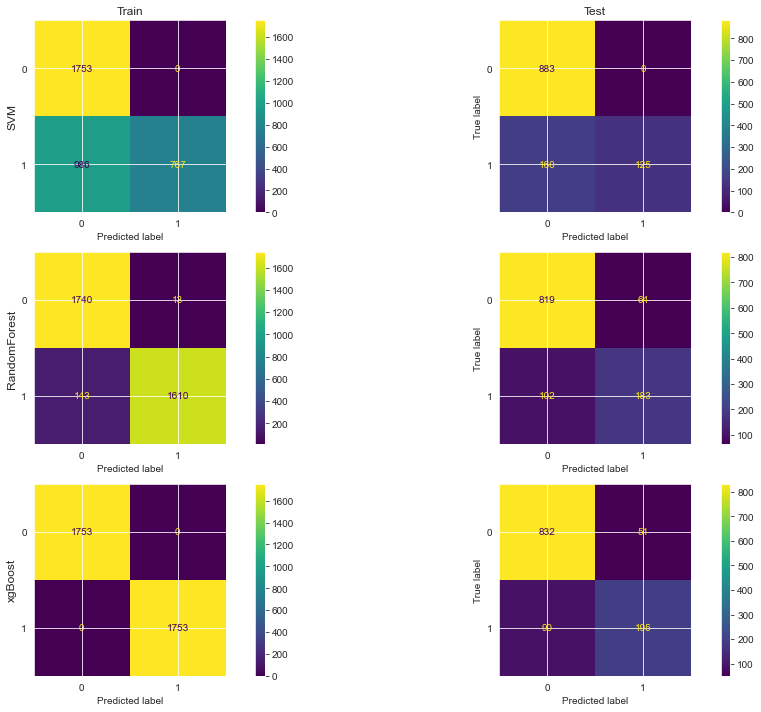

SMOTE+ENN
Buscando (SVM)
Mejores parametros: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
test acurracy 24.40% test recall 100.00% test precision 24.40%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 250, 'random_state': 42}
test acurracy 84.08% test recall 71.23% test precision 66.12%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 84.85% test recall 72.63% test precision 67.65%


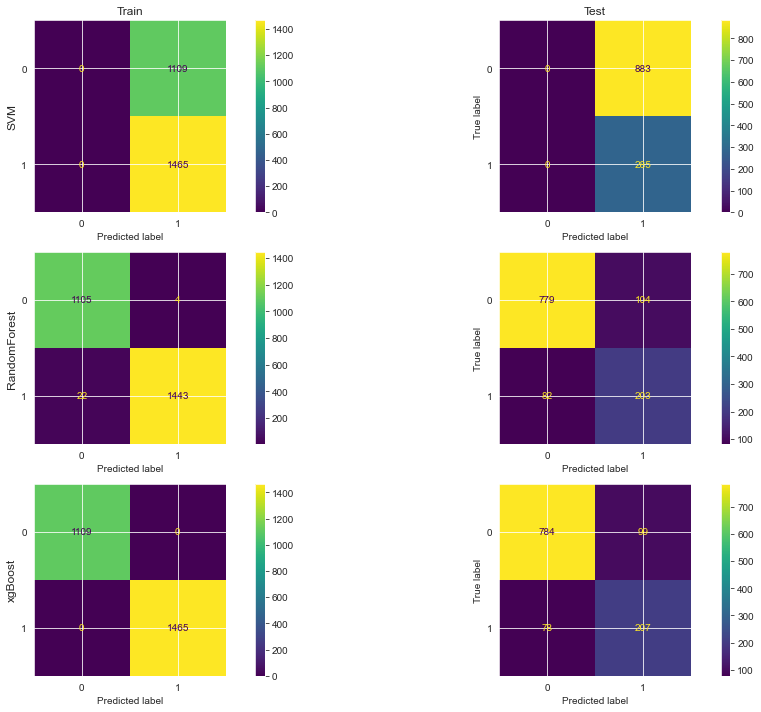

In [59]:
param_svm = {
    'C' : [0.001],
    'kernel': ['rbf'],
    'gamma' :[0.001]
}


param_rf = {
    'n_estimators':[250],
    'max_depth' : [8],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [7],
    'learning_rate' : [0.1],
    'n_estimators' : [200],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
samplers = [SMOTETomek(),SMOTEENN()]
combine = ['SMOTE+Tomek','SMOTE+ENN']
entrenados = []





for algo,comb in zip(samplers,combine):

    print(comb)
    X_res,Y_res = algo.fit_resample(X_train,Y_train)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True)
        busqueda.fit(X_res,Y_res)
        print('Buscando ({})'.format(modelo))
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                        recall_score(Y_test,busqueda.predict(X_test)),
                                                                                        precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            Y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

## Combinada DELTA - Optimista

SMOTE+Tomek
Conjunto de entrenamiento (resampleado) Counter({0: 1751, 1: 1751})
Conjunto de prueba Counter({0: 883, 1: 285})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 87.41% test recall 63.86% test precision 80.53%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 89.04% test recall 69.82% test precision 82.57%


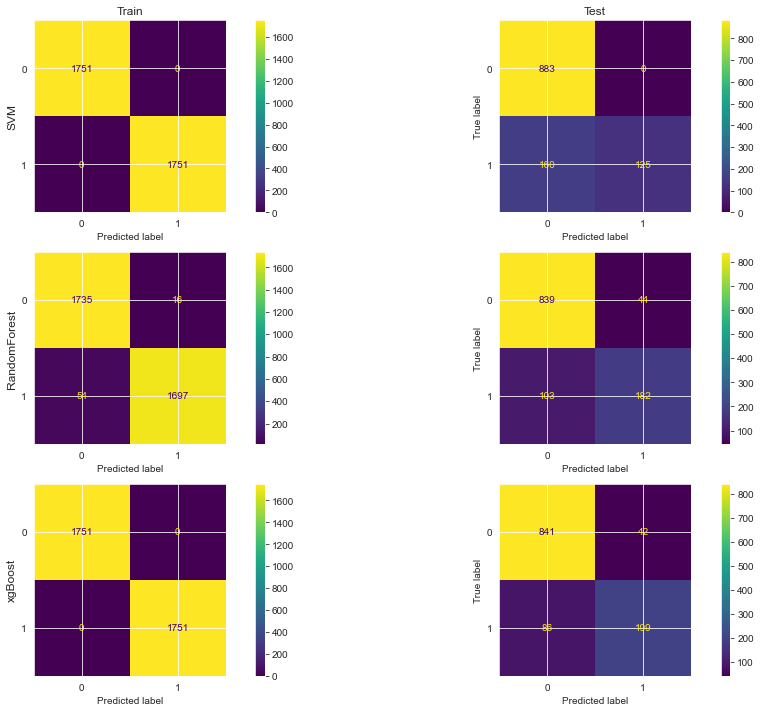

SMOTE+NN
Conjunto de entrenamiento (resampleado) Counter({1: 1463, 0: 1104})
Conjunto de prueba Counter({0: 883, 1: 285})
SVM
Mejores parametros: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 86.30% test recall 43.86% test precision 100.00%
RandomForest
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 83.56% test recall 71.58% test precision 64.76%
xgBoost
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.01}
test acurracy 84.67% test recall 77.89% test precision 65.68%


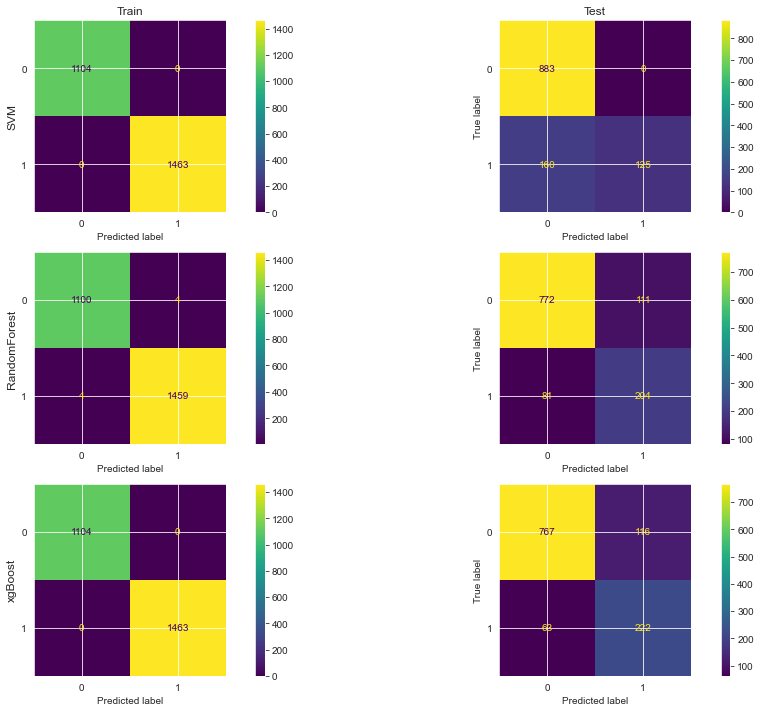

In [60]:
### APARECIDOS
param_svm = {
    'C' : [0.0001,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001]
}


param_rf = {
    'n_estimators':[200,300],
    'max_depth' : [8],
    'criterion' : ['entropy','gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [5,6],
    'learning_rate' : [0.1],
    'n_estimators' : [250,300],
    'gamma' : [0],
    'reg_alpha' : [0.01,0.1],
    'random_state': [42]
}

modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
oversampling = [SMOTETomek(),SMOTEENN()]
oversamplers = ['SMOTE+Tomek','SMOTE+NN']
entrenados = []

for algo,sampler in zip(oversampling,oversamplers):
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    print(sampler)
    X_res, y_res = algo.fit_resample(X_train, Y_train)
    X_res = calcularDeltas(X_res,5,columnas_anuales)
    X_res.fillna(value=0.0,inplace=True)
    X_res = infnan(X_res)
    print('Conjunto de entrenamiento (resampleado) %s' % Counter(y_res))
    print('Conjunto de prueba %s' % Counter(Y_test))

    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):

        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True,n_jobs=-1)
        busqueda.fit(X_res,y_res)
        print(modelo)
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test_deltas,Y_test),
                                                                                     recall_score(Y_test,busqueda.predict(X_test_deltas)),
                                                                                     precision_score(Y_test,busqueda.predict(X_test_deltas))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test_deltas,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

        for ax,col in zip(axes[0],['Train','Test']):
            ax.set_title(col)
        for ax, row in zip(axes[:,0], modelos):
            ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()